In [ ]:
!pip install cupy-cuda11x


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.4/95.4 MB 14.0 MB/s eta 0:00:00


In [ ]:
import cupy as cp
import cv2
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.patches import Rectangle
# Load your data here
# Assuming video_rgb is loaded as a NumPy array
#video_rgb = cp.asarray(video_rgb)


In [ ]:
# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Function to load video into a NumPy array
def load_video_to_numpy(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return np.array(frames)

dict_keys(['__header__', '__version__', '__globals__', 'I'])
Frames shape: (360, 640, 3, 600)


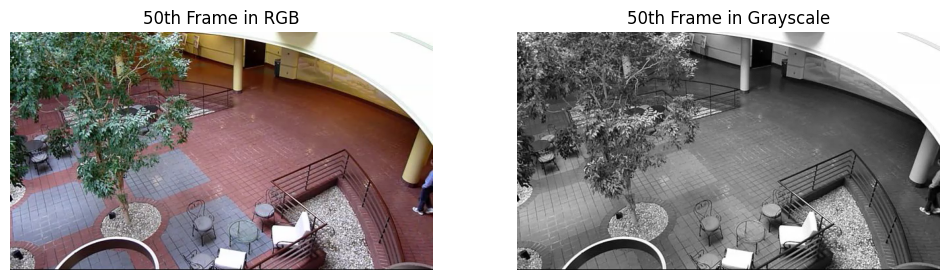

In [ ]:
from scipy.io import loadmat
from skimage.color import rgb2gray
import numpy as np

# Load the video data
video_data_path = '/content/drive/My Drive/EE 243/Assignments/Assignment 3/video.mat'
video_data = loadmat(video_data_path)
video_np = load_video_to_numpy(video_data_path)

# Check which variables are loaded
print(video_data.keys())

# Access the frames using the key 'I'
frames = video_data['I']

# Verify the shape of the frames
print(f"Frames shape: {frames.shape}")

# Extract the 50th frame in RGB (assuming zero-based indexing)
frame_50_rgb = frames[:, :, :, 49]

# Convert the frame to grayscale
frame_50_gray = rgb2gray(frame_50_rgb)

# Plot both RGB and grayscale versions of the 50th frame
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# RGB version
ax[0].imshow(frame_50_rgb)
ax[0].axis("off")
ax[0].set_title("50th Frame in RGB")

# Grayscale version
ax[1].imshow(frame_50_gray, cmap="gray")
ax[1].axis("off")
ax[1].set_title("50th Frame in Grayscale")

plt.show()

# Ensure you're referencing the correct variable from the loaded data
#video_rgb = video_data['<actual_variable_name>']  # Replace with the variable name containing the video frames
# Convert the NumPy array to a CuPy array
video_rgb = cp.asarray(video_np)

# Sample display video code

In [ ]:
from matplotlib import animation

# Extract the frames from the correct variable name (replace 'I' with the actual key)
video_rgb = video_data['I']

# Function to display video as animation
def display_video(video):
  fig = plt.figure(figsize=(5,5))
  mov = []
  for i in range(video.shape[3]):
    img = plt.imshow(video[:,:,:,i],animated=True)
    plt.axis('off')
    mov.append([img])

  movie = animation.ArtistAnimation(fig,mov,interval=20,repeat_delay=1000)
  plt.close()
  return movie

# Display the video animation
HTML(display_video(video_rgb).to_html5_video())



In [ ]:
from scipy import io
from skimage.color import rgb2gray

def load_video(file_path):
  # load video
  video_rgb = io.loadmat(file_path)['I'] # video loaded with shape HxWx3XT where T is the total number of frames

  # Initialize empty array for grayscale video
  height, width, channels, num_frames = video_rgb.shape
  video_grayscale = np.empty((height, width, num_frames), dtype=np.float32) # convert each frame of above video to grayscale

  # Convert each frame to grayscale
  for i in range(num_frames):
      video_grayscale[:, :, i] = rgb2gray(video_rgb[:, :, :, i])

  return video_rgb, video_grayscale

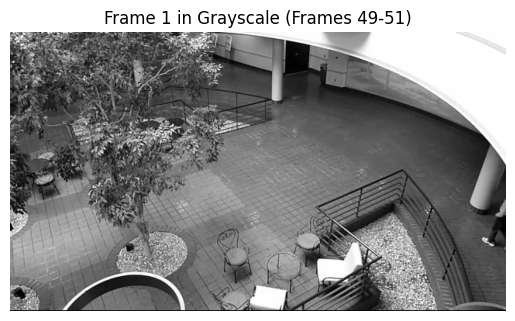

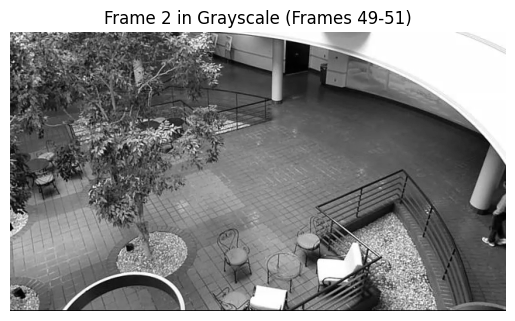

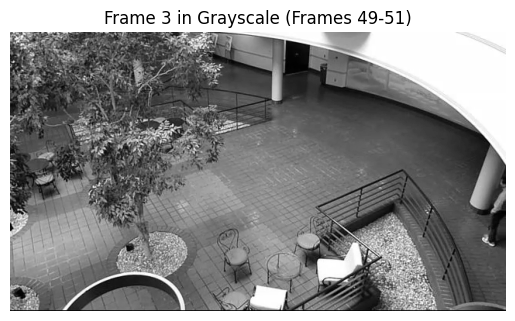

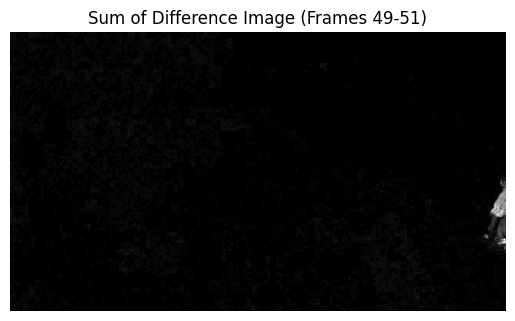

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def getSumOfDiff(image_set):
    # Ensure image_set has consistent shape
    num_frames = image_set.shape[2]
    height, width = image_set.shape[0], image_set.shape[1]
    sod_image = np.zeros((height, width), dtype=np.float32)

    # Compute absolute differences between pairs of frames
    for i in range(num_frames - 1):
        for j in range(i + 1, num_frames):
            sod_image += np.abs(image_set[:,:,i] - image_set[:,:,j])

    # Normalize by the number of pairs
    num_pairs = num_frames * (num_frames - 1) // 2
    sod_image /= num_pairs

    # Normalize the SOD image to the [0, 1] range
    #sod_image = (sod_image - sod_image.min()) / (sod_image.max() - sod_image.min())

    return sod_image

# Load the video data and convert to grayscale
video_rgb, video_grayscale = load_video(video_data_path)

# Verify individual frames
frames_49_51 = video_grayscale[:, :, 48:51]
for i in range(frames_49_51.shape[2]):
    plt.imshow(frames_49_51[:, :, i], cmap='gray')
    plt.axis('off')
    plt.title(f"Frame {i + 1} in Grayscale (Frames 49-51)")
    plt.show()

# Compute and visualize the sum of differences image
sod_image = getSumOfDiff(frames_49_51)

plt.imshow(sod_image, cmap='gray')
plt.axis('off')
plt.title("Sum of Difference Image (Frames 49-51)")
plt.show()


In [ ]:
import cv2
from skimage.measure import label, regionprops

def getDetections(sod_image, threshold_value=50):
  # sod_image is a sum of difference image
  # Returns a list bounding boxes of clustered motion information from sod_image
  # Convert SOD image to a binary image using a threshold
    # Convert SOD image to a binary image using a threshold
    # Note: sod_image should be properly scaled or normalized if needed before multiplying by 255
    # _, thresh = cv2.threshold((sod_image * 255).astype(np.uint8), threshold_value, 255, cv2.THRESH_BINARY)
     # Ensure the SOD image is scaled to the full [0, 255] range of uint8
    if sod_image.dtype != np.uint8:
        # Normalize the SOD image to the [0, 1] range if it's not already
        sod_image = (sod_image - sod_image.min()) / (sod_image.max() - sod_image.min())
        # Scale to [0, 255] and convert to uint8
        sod_image = (sod_image * 255).astype(np.uint8)

    # Threshold to create a binary image
    _, thresh = cv2.threshold(sod_image, threshold_value, 255, cv2.THRESH_BINARY)

    # Apply morphological operations to clean up the image
    kernel = np.ones((3, 3), np.uint8)
    cleaned_image = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    cleaned_image = cv2.dilate(cleaned_image, kernel, iterations=2)

    # Find contours from the cleaned binary image
    contours, _ = cv2.findContours(cleaned_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate bounding boxes from the contours
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]

    return bounding_boxes

'\n    labeled_image = label(cleaned_image)\n\n    # Calculate bounding boxes from the contours\n    bounding_boxes = []\n    for contour in regionprops(labeled_image):\n        min_x, min_y, max_x, max_y = contour.bounding_box\n        bounding_boxes.append([min_x, min_y, max_y - min_y, max_x - min_x])\n\n    return bounding_boxes\n'

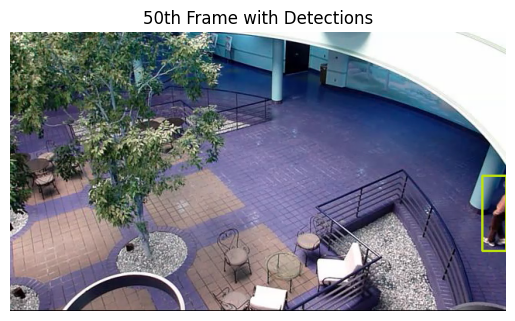

'\n# Load the corresponding RGB frame and overlay bounding boxes\nif video_rgb.shape[3] > 49:\n    frame_with_boxes = boundingBoxes(video_rgb[:,:,:,49].copy(), bounding_boxes)\n     # Convert the frame from BGR to RGB for correct color rendering in Matplotlib\n    frame_with_boxes = cv2.cvtColor(frame_with_boxes, cv2.COLOR_BGR2RGB)\n    plt.imshow(frame_with_boxes)\n    plt.axis(\'off\')\n    plt.title("50th Frame with Detection (RGB)")\n    plt.show()\nelse:\n    print("Not enough frames in RGB video.")\n\n\nvideo_rgb.shape[3] > 49\nframe_with_boxes = boundingBoxes(frame_50_rgb.copy(), bounding_boxes)\n#display_frame(frame_with_boxes, title=\'50th Frame with Detections (RGB)\')\n\nplt.imshow(frame_with_boxes)\nplt.axis(\'off\')\nplt.title("50th Frame with Detection (RGB)")\nplt.show()\n\nsod_image = getSumOfDiff(frames_49_51)\nbounding_boxes = getDetections(sod_image, threshold_value=25)\n\nvideo_rgb.shape[3] > 49\nframe_with_boxes = boundingBoxes(frames_49_51.copy(), bounding_boxes)\

In [ ]:
def boundingBoxes(frame, bounding_boxes):
  for bounding_box in bounding_boxes:
    x, y, width, height = bounding_box
    cv2.rectangle(frame, (x,y), (x + width, y + height), (15,225,190), 2)
  return frame

sod_image = getSumOfDiff(frames_49_51)
bounding_boxes = getDetections(sod_image, threshold_value=10)

# Assuming video_rgb is loaded and has at least one frame
frame = video_rgb[:,:,:,49].copy() if video_rgb.shape[3] > 49 else print("Not enough frames in RGB video.")
frame_with_boxes = boundingBoxes(frame, bounding_boxes)


# Display the result
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(frame_with_boxes, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
plt.axis('off')
plt.title("50th Frame with Detections")
plt.show()

In [ ]:
import torchvision.transforms as transforms
# load_resnet
import torch
import torch.nn as nn
import torchvision.models as models

# Load a pre-trained ResNet-50 model and prepare it as a feature extractor
def load_resnet_feature_extractor():
    #model = models.resnet50(pretrained=True)  # Ensure you have pretrained=True or similar arguments based on your setup
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    # Remove the last layer to convert it into a feature extractor
    model = nn.Sequential(*list(model.children())[:-1])
    model.eval()  # Set the model to evaluation mode
    return model

def getDeepFeatures(image,bbox,model):

  device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
  model.to(device)
  model.eval()
  ###########################################################################
  ########################### FILL YOUR CODE WILL ###########################
  ###########################################################################
  if len(bbox) == 0:
    return np.array([])

  # DEFINE TRANSFORM TO CONVERT TO TENSOR
  transform = transforms.Compose([
      transforms.ToPILImage()
      , transforms.Resize((224,224))
      , transforms.ToTensor()
      # RGB mean & std were derived from ImageNet dataset
      , transforms.Normalize(mean=[0.485, 0.456, 0.406]
                             , std=[0.229, 0.224, 0.225])
  ])

  # DEFINE FEATURES ARRAY BASED ON SIZE OF BOUNDING BOX
  feat = []

  with torch.no_grad():
    # FOR EACH BOUNDING BOX EXTRACT FEATURES, BRING TO CPU AND ADD TO feat
    # YOU NEED TO FIRST CROP THE BOUNDING BOX PORTION OF THE IMAGE
    # APPLY TRANSFORMS AND MAKE SURE TO REARRANGE IMAGE TO 3XHXW
    with torch.no_grad():
      for x, y, width, height in bbox:
        crop_image = image[y:y+height, x:x+width]
        if crop_image.size == 0:
          continue
        # Apply transformations & batch dimension
        input_tensor = transform(crop_image).unsqueeze(0).to(device)

        with torch.no_grad():
          output = model(input_tensor)
          feat.append(output.squeeze().cpu().numpy())

  feat = np.array(feat) #np.vstack(feat)

  # returns feat a numpy array of size N1x2048 where N1=bbox.shape[0]
  #return feat if feat else np.array([])
  return np.array(feat) if len(feat) > 0 else np.array([])

In [ ]:
# Assuming the 'video_rgb' and 'video_grayscale' are properly loaded as per your earlier description
resnet_model = load_resnet_feature_extractor()
# Load and prepare the ResNet model
#resnet_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

#resnet_model = nn.Sequential(*list(resnet_model.children())[:-1])


# Check if the 50th frame exists
if video_rgb.shape[3] > 49:
    frame_set = video_grayscale[:, :, 47:52]  # Extract frames 48 to 52 (index 47 to 51)
    sod_image50 = getSumOfDiff(frame_set)
    frame_with_boxes = video_rgb[:, :, :, 49].copy()  # Copy the 50th frame from RGB
    bounding_boxes = getDetections(sod_image50, threshold_value=25)  # Assume getDetections is properly defined
    deep_features = getDeepFeatures(frame_with_boxes, bounding_boxes, resnet_model)
    print("Extracted features shape:", deep_features.shape if deep_features.size > 0 else "No features extracted")
else:
    print("Not enough frames in RGB video.")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 51.3MB/s]


Extracted features shape: (1, 2048)


In [ ]:
# Install torchreid if not already installed
#!pip install torchreid

# Import necessary libraries
import torchreid
import torch.nn as nn


# load video
file_path = video_data_path # path to video.mat
video_rgb,video_grayscale = load_video(file_path)

# get sample sum of difference image for 50th frame
offset = 50
D1 = getSumOfDiff(video_grayscale[:,:,offset-1:offset+1])

# Write code to display D1

# get bboxes for 50th frame
bbox1 = getDetections(D1)

# Write code to display bbox1 overlaying on top of video_rgb[:,:,:,50]

detections = []
detections.append((offset,bbox1)) # appends frame number and its corresponding detections
matchings = []
model = torchreid.models.build_model(name='resnet50',
                                     num_classes=10,
                                     loss='softmax',
                                     pretrained=True
                                    )
# FILL CODE FOR FEATURE EXTRACTION FROM PENULTIMATE LAYER.
# YOU NEED TO REMOVE LAST LAYER OF MODEL DEFINED ABOVE.
# AFTER REMOVING LAST LAYER YOUR MODEL WILL OUTPUT A FEATURE OF LENGTH 2048

# Removing the classifier to keep only the feature extraction part
# The specific layers to remove can depend on the model architecture; assuming a typical setup:
model = nn.Sequential(*list(model.children())[:-1])  # Removes the last module typically a classifier

extractor = model  # Use this as the feature extractor

feat1 = getDeepFeatures(video_rgb[:,:,:,offset],bbox1,extractor)

for i in range(offset,video_rgb.shape[3]-2):

    D2 = getSumOfDiff(video_grayscale[:,:,i:i+2])
    bbox2 = getDetections(D2)

    if len(bbox2) == 0:
      continue

    detections.append((i+1,bbox2))
    feat2 = getDeepFeatures(video_rgb[:,:,:,i+1],bbox2,extractor)


    M = getMatches(feat1,feat2);

    if len(M) == 0:
      continue

    matchings.append((i,i+1,M)) # appends the frame t and frame t+1 with their corresponding matchings

    D1 = D2;
    bbox1 = bbox2;
    feat1 = feat2;

# Write code to display the bounding boxes frame by frame as a video using video_rgb and the list detections
# Write code to display the matched points b/w frame t and t+1 as a video using video_rgb and the list matchings
# use the centroid of the cooresponding matched bounding boxes as coordinates
# for matchings display reuse your assignment1 code to get the frame t->t+1 matchings
# refer to cell 2 for a sample animation code you need to modify it

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.7/92.7 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torchreid: filename=torchreid-0.2.5-py3-none-any.whl size=144325 sha256=0dd35735f07ea44e172ae66631688eacf480dba48a62807056bbb078d898ae8e
  Stored in directory: /root/.cache/pip/wheels/bb/2d/36/816a48465cefd3e58be0317648a4c52ce39ae817f935212099
Successfully built torchreid


/usr/local/lib/python3.10/dist-packages/torchreid/reid/metrics/rank.py:11: UserWarning: Cython evaluation (very fast so highly recommended) is unavailable, now use python evaluation.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 374MB/s]


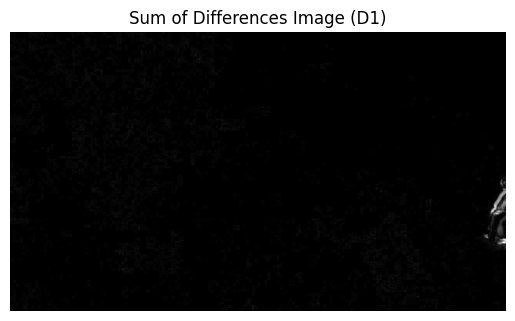

Min pixel value in D1: 0.0
Max pixel value in D1: 0.7561074495315552


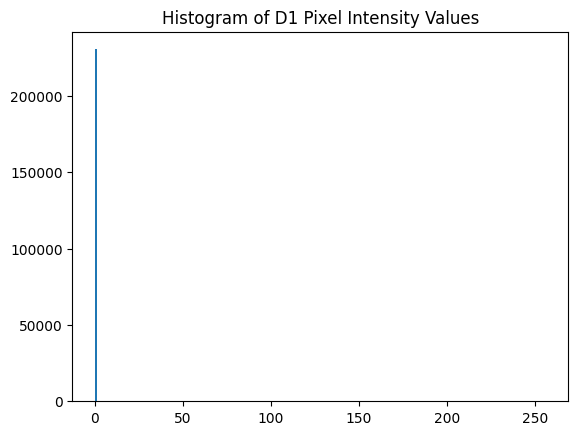

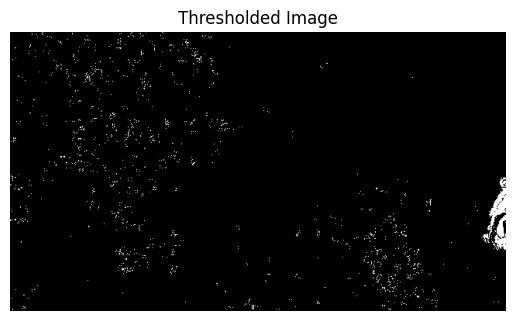

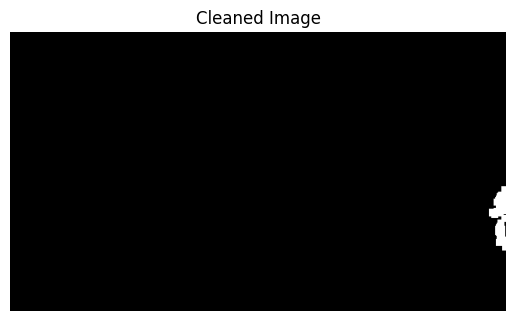

Frame dimensions: (360, 640, 3)
Bounding boxes: [(618, 199, 22, 83)]
Drawing box at (618, 199) with width 22 and height 83


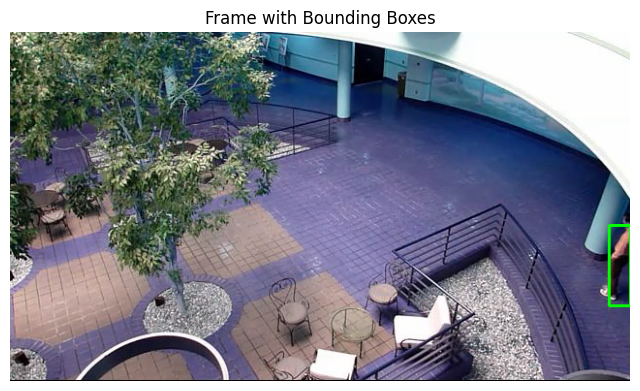

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Assuming getSumOfDiff function is already defined
def getSumOfDiff(video_grayscale_segment):
    return np.abs(np.diff(video_grayscale_segment, axis=2)).sum(axis=2)

def getDetections(D):
    # Inspect pixel intensity values
    print(f"Min pixel value in D1: {D.min()}")
    print(f"Max pixel value in D1: {D.max()}")

    # Plot histogram of D1
    plt.hist(D.ravel(), bins=256, range=[0,256])
    plt.title('Histogram of D1 Pixel Intensity Values')
    plt.show()

    # Apply a dynamic threshold to the difference image to get a binary image
    threshold_value = D.mean() + 2 * D.std()  # Dynamic threshold based on mean and standard deviation
    _, thresh = cv2.threshold(D, threshold_value, 255, cv2.THRESH_BINARY)
    plt.imshow(thresh, cmap='gray')
    plt.title('Thresholded Image')
    plt.axis('off')
    plt.show()

    # Apply morphological operations to clean up the image
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    cleaned = cv2.dilate(cleaned, kernel, iterations=2)
    plt.imshow(cleaned, cmap='gray')
    plt.title('Cleaned Image')
    plt.axis('off')
    plt.show()

    # Find contours in the cleaned binary image
    contours, _ = cv2.findContours(cleaned.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate bounding boxes from the contours
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]

    return bounding_boxes

def display_bboxes_on_frame(frame, bboxes):
    """Draws bounding boxes on the frame."""
    frame_display = frame.copy()

    # Print frame dimensions for debugging
    print(f"Frame dimensions: {frame_display.shape}")

    # Convert frame to a displayable format if necessary
    if frame_display.ndim == 3 and frame_display.shape[2] == 3:
        frame_display = cv2.cvtColor(frame_display, cv2.COLOR_BGR2RGB)

    print("Bounding boxes:", bboxes)  # Debugging: Check bounding box coordinates
    for x, y, w, h in bboxes:
        print(f"Drawing box at ({x}, {y}) with width {w} and height {h}")  # More detailed debug info
        cv2.rectangle(frame_display, (x, y), (x + w, y + h), (15,225,190), 2)  # Draw rectangle with yellowish color

    plt.figure(figsize=(8, 6))
    plt.imshow(frame_display)
    plt.title('Frame with Bounding Boxes')
    plt.axis('off')
    plt.show()

# Load video and compute D1
file_path = '/content/drive/My Drive/EE 243/Assignments/Assignment 3/video.mat'  # replace with your actual path
video_rgb, video_grayscale = load_video(file_path)
offset = 50
D1 = getSumOfDiff(video_grayscale[:, :, offset-1:offset+1])
plt.imshow(D1, cmap='gray')
plt.title('Sum of Differences Image (D1)')
plt.axis('off')
plt.show()

# Calculate bounding boxes
bbox1 = getDetections(D1)

# Display bounding boxes on the frame
display_bboxes_on_frame(video_rgb[:, :, :, 50], bbox1)


In [ ]:
def getSumOfDiff(video_grayscale_segment):
    diff = np.abs(np.diff(video_grayscale_segment, axis=2))
    return diff.sum(axis=2)

def non_max_suppression(bboxes, overlap_threshold=0.3):
    """
    Perform non-maximum suppression to eliminate overlapping boxes.

    Returns:
    - List of filtered bounding boxes.
    """
    if len(bboxes) == 0:
        return []

    # Convert bounding boxes to numpy array format for easier manipulation
    boxes = np.array(bboxes)

    # Compute the area of each bounding box
    areas = (boxes[:, 2] - boxes[:, 0] + 1) * (boxes[:, 3] - boxes[:, 1] + 1)

    # Sort the bounding boxes by their bottom-right y-coordinate
    order = boxes[:, 3].argsort()

    picked_boxes = []

    while len(order) > 0:
        # Pick the box with the largest bottom-right y-coordinate
        i = order[-1]
        picked_boxes.append(bboxes[i])

        # Compute the intersection area with the rest of the boxes
        xx1 = np.maximum(boxes[i, 0], boxes[order[:-1], 0])
        yy1 = np.maximum(boxes[i, 1], boxes[order[:-1], 1])
        xx2 = np.minimum(boxes[i, 2], boxes[order[:-1], 2])
        yy2 = np.minimum(boxes[i, 3], boxes[order[:-1], 3])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        inter = w * h

        # Compute the overlap ratio
        overlap = inter / areas[order[:-1]]

        # Remove boxes that overlap significantly
        order = order[np.where(overlap <= overlap_threshold)[0]]

    return picked_boxes

def getDetections(sod_image, threshold_value=20, nms_threshold=0.3):
    if sod_image.dtype != np.uint8:
        sod_image = (sod_image - sod_image.min()) / (sod_image.max() - sod_image.min())
        sod_image = (sod_image * 255).astype(np.uint8)

    _, thresh = cv2.threshold(sod_image, threshold_value, 255, cv2.THRESH_BINARY)
    plt.imshow(thresh, cmap='gray')
    plt.title('Thresholded Image')
    plt.axis('off')
    plt.show()

    kernel = np.ones((3, 3), np.uint8)
    cleaned_image = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    cleaned_image = cv2.dilate(cleaned_image, kernel, iterations=2)

    plt.imshow(cleaned_image, cmap='gray')
    plt.title('Cleaned Image')
    plt.axis('off')
    plt.show()

    contours, _ = cv2.findContours(cleaned_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]

    print(f"Detected {len(bounding_boxes)} bounding boxes")

    expanded_boxes = []
    for x, y, w, h in bounding_boxes:
        margin = 10
        expanded_boxes.append((x - margin, y - margin, w + 2 * margin, h + 2 * margin))

    # Apply Non-Maximum Suppression
    final_boxes = non_max_suppression(expanded_boxes, nms_threshold)

    return final_boxes


def getMatches(feat1, feat2):
    if feat1.size == 0 or feat2.size == 0:
        return []
    threshold_value = 0.5
    similar = cosine_similarity(feat1, feat2)
    matches = [(i, np.argmax(sim)) for i, sim in enumerate(similar) if sim[np.argmax(sim)] > threshold_value]
    return matches

def getDeepFeatures(image, bbox, model):
    device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    if len(bbox) == 0:
        return np.array([])
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    feat = []
    with torch.no_grad():
        for x, y, width, height in bbox:
            x = max(0, x)
            y = max(0, y)
            width = min(image.shape[1] - x, width)
            height = min(image.shape[0] - y, height)
            crop_image = image[y:y+height, x:x+width]
            if crop_image.size == 0:
                continue
            input_tensor = transform(crop_image).unsqueeze(0).to(device)
            output = model(input_tensor)
            feat.append(output.squeeze().cpu().numpy())
    return np.array(feat) if len(feat) > 0 else np.array([])


def load_video(file_path):
    video_rgb = io.loadmat(file_path)['I']
    height, width, channels, num_frames = video_rgb.shape
    video_grayscale = np.empty((height, width, num_frames), dtype=np.float32)
    for i in range(num_frames):
        video_grayscale[:, :, i] = rgb2gray(video_rgb[:, :, :, i])
    return video_rgb, video_grayscale



In [ ]:
def getSumOfDiff(video_grayscale_segment):
    diff = np.abs(np.diff(video_grayscale_segment, axis=2))
    return diff.sum(axis=2)

def non_max_suppression(bboxes, overlap_threshold=0.5):
    if len(bboxes) == 0:
        return []

    boxes = np.array(bboxes)
    areas = (boxes[:, 2] - boxes[:, 0] + 1) * (boxes[:, 3] - boxes[:, 1] + 1)
    order = boxes[:, 3].argsort()
    picked_boxes = []

    while len(order) > 0:
        i = order[-1]
        picked_boxes.append(bboxes[i])
        xx1 = np.maximum(boxes[i, 0], boxes[order[:-1], 0])
        yy1 = np.maximum(boxes[i, 1], boxes[order[:-1], 1])
        xx2 = np.minimum(boxes[i, 2], boxes[order[:-1], 2])
        yy2 = np.minimum(boxes[i, 3], boxes[order[:-1], 3])
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        inter = w * h
        overlap = inter / areas[order[:-1]]
        order = order[np.where(overlap <= overlap_threshold)[0]]

    return picked_boxes

def getDetections(sod_image, threshold_value=20, nms_threshold=0.5):
    if sod_image.dtype != np.uint8:
        sod_image = (sod_image - sod_image.min()) / (sod_image.max() - sod_image.min())
        sod_image = (sod_image * 255).astype(np.uint8)

    _, thresh = cv2.threshold(sod_image, threshold_value, 255, cv2.THRESH_BINARY)

    kernel = np.ones((3, 3), np.uint8)
    cleaned_image = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    cleaned_image = cv2.dilate(cleaned_image, kernel, iterations=2)

    contours, _ = cv2.findContours(cleaned_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]

    expanded_boxes = []
    for x, y, w, h in bounding_boxes:
        margin_x = int(w * 0.5)
        margin_y = int(h * 0.5)
        expanded_boxes.append((x - margin_x, y - margin_y, x + w + margin_x, y + h + margin_y))

    final_boxes = non_max_suppression(expanded_boxes, nms_threshold)
    return final_boxes

def getMatches(feat1, feat2):
    if feat1.size == 0 or feat2.size == 0:
        return []
    threshold_value = 0.5
    similar = cosine_similarity(feat1, feat2)
    matches = [(i, np.argmax(sim)) for i, sim in enumerate(similar) if sim[np.argmax(sim)] > threshold_value]
    return matches

def getDeepFeatures(image, bbox, model):
    device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    if len(bbox) == 0:
        return np.array([])
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    feat = []
    with torch.no_grad():
        for x1, y1, x2, y2 in bbox:
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(image.shape[1], x2)
            y2 = min(image.shape[0], y2)
            crop_image = image[y1:y2, x1:x2]
            if crop_image.size == 0:
                continue
            input_tensor = transform(crop_image).unsqueeze(0).to(device)
            output = model(input_tensor)
            feat.append(output.squeeze().cpu().numpy())
    return np.array(feat) if len(feat) > 0 else np.array([])

def load_video(file_path):
    video_rgb = loadmat(file_path)['I']
    height, width, channels, num_frames = video_rgb.shape
    video_grayscale = np.empty((height, width, num_frames), dtype=np.float32)
    for i in range(num_frames):
        video_grayscale[:, :, i] = rgb2gray(video_rgb[:, :, :, i])
    return video_rgb, video_grayscale


In [ ]:
# Load video
file_path = '/content/drive/My Drive/EE 243/Assignments/Assignment 3/video.mat'  # Replace with your actual file path
video_rgb, video_grayscale = load_video(file_path)
offset = 50

# Get initial detections
D1 = getSumOfDiff(video_grayscale[:, :, offset-1:offset+2])
bbox1 = getDetections(D1)

# Plot D1 and initial bounding boxes (only for initial visualization)
plt.imshow(D1, cmap='gray')
plt.title('Sum of Differences Image (D1)')
plt.axis('off')
plt.show()

frame = video_rgb[:, :, :, offset].copy()
for box in bbox1:
    x1, y1, x2, y2 = box
    cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
plt.imshow(frame)
plt.title('Initial Bounding Boxes')
plt.axis('off')
plt.show()

detections = [(offset, bbox1)]
matchings = []

# Load model and set up extractor
model = torchreid.models.build_model(name='resnet50', num_classes=10, loss='softmax', pretrained=True)
extractor = nn.Sequential(*list(model.children())[:-1])

feat1 = getDeepFeatures(video_rgb[:, :, :, offset], bbox1, extractor)

# Process frames
for i in range(offset, video_rgb.shape[3] - 2):
    D2 = getSumOfDiff(video_grayscale[:, :, i:i+3])
    bbox2 = getDetections(D2)

    if len(bbox2) == 0:
        continue

    detections.append((i + 1, bbox2))
    feat2 = getDeepFeatures(video_rgb[:, :, :, i + 1], bbox2, extractor)

    M = getMatches(feat1, feat2)
    if len(M) == 0:
        continue

    matchings.append((i, i + 1, M))
    D1 = D2
    bbox1 = bbox2
    feat1 = feat2

# Plot detections and matched points
fig, ax = plt.subplots(figsize=(10, 8))

def update(frame_index):
    ax.clear()
    frame = video_rgb[:, :, :, frame_index].copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    ax.imshow(frame)

    for f_idx, bboxes in detections:
        if f_idx == frame_index:
            for x1, y1, x2, y2 in bboxes:
                x1 = max(0, x1)
                y1 = max(0, y1)
                x2 = min(frame.shape[1], x2)
                y2 = min(frame.shape[0], y2)
                ax.add_patch(Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='yellow', linewidth=2))

    ax.set_title(f"Frame {frame_index}")
    ax.axis('off')

ani = animation.FuncAnimation(fig, update, frames=range(offset, video_rgb.shape[3] - 2), repeat=False)
HTML(ani.to_html5_video())

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
fig = plt.figure(figsize=(10, 5))
mov = []

# Create animation frames
for i, (frame1, frame2, matches) in enumerate(matchings):
    frame = np.ascontiguousarray(np.hstack((video_rgb[:, :, :, frame1], video_rgb[:, :, :, frame2])))
    bboxes1 = detections[i][1]
    bboxes2 = detections[i+1][1]
    for m in matches:
        centrd1 = (bboxes1[m[0]][0] + (bboxes1[m[0]][2] - bboxes1[m[0]][0]) // 2,
                     bboxes1[m[0]][1] + (bboxes1[m[0]][3] - bboxes1[m[0]][1]) // 2)
        centrd2 = (bboxes2[m[1]][0] + (bboxes2[m[1]][2] - bboxes2[m[1]][0]) // 2 + video_rgb.shape[1],
                     bboxes2[m[1]][1] + (bboxes2[m[1]][3] - bboxes2[m[1]][1]) // 2)
        cv2.line(frame, centrd1, centrd2, (204, 204, 255), 2)

    img = plt.imshow(frame, animated=True)
    plt.axis('off')
    mov.append([img])

movie = animation.ArtistAnimation(fig, mov, interval=20, repeat_delay=1000)
plt.close()
HTML((movie).to_html5_video())